In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import polars as pl
import datetime
import altair as alt

In [2]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [3]:
# Perform depth-first search (DFS) to find all conjugated bond paths
def dfs(graph, bond_idx, visited):
    visited.add(bond_idx)
    max_chain = []
    for neighbor, is_connected in enumerate(graph[bond_idx]):
        if is_connected and neighbor not in visited:
            chain = dfs(graph, neighbor, visited)
            if len(chain) > len(max_chain):
                max_chain = chain
    visited.remove(bond_idx)
    return [bond_idx] + max_chain

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Geometry import Point2D
from IPython.display import SVG  # For displaying SVG directly in Jupyter notebooks

# Function to label bond indices on a molecule
def label_bonds(mol):
    # Generate 2D coordinates for visualization
    Chem.rdDepictor.Compute2DCoords(mol)

    # Define image size and initialize an SVG drawer
    drawer = Draw.MolDraw2DSVG(300, 300)

    # Draw the molecule first
    drawer.DrawMolecule(mol)

    # Add bond numbers in red
    for bond in mol.GetBonds():
        idx = bond.GetIdx()
        begin_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetBeginAtomIdx())
        end_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetEndAtomIdx())

        # Calculate midpoint of bond
        mid_x = (begin_atom_pos.x + end_atom_pos.x) / 2
        mid_y = (begin_atom_pos.y + end_atom_pos.y) / 2

        # Offset the y coordinate to move the label just above the bond
        offset_y = 1.1  # Adjust this value to control how far above the bond the label is
        mid_point = Point2D(mid_x, mid_y + offset_y)

        # Set label color to red and add bond index at the offset midpoint
        drawer.SetColour((1.0, 0.0, 0.0))  # Red color (R, G, B)
        drawer.DrawString(str(idx), mid_point)

    # Finish drawing
    drawer.FinishDrawing()

    # Get the SVG text
    svg = drawer.GetDrawingText()

    # Display the SVG image (if you're in a Jupyter notebook)
    display(SVG(svg))

    # Save the SVG to a file (optional)
    with open("molecule_with_bond_numbers.svg", "w") as f:
        f.write(svg)

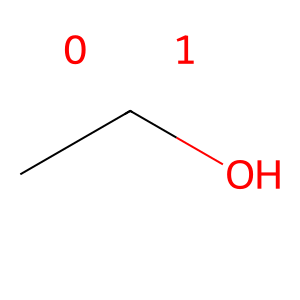

In [5]:
label_bonds(Chem.MolFromSmiles("CCO"))

In [6]:
from rdkit import Chem
import numpy as np

def get_longest_conjugated_bond_chain(mol):
    num_bonds = mol.GetNumBonds()
    
    # Create a list to store conjugated bond indices
    conjugated_bonds = [bond.GetIdx() for bond in mol.GetBonds() if bond.GetIsConjugated()]
    num_conjugated_bonds = len(conjugated_bonds)
    # print(f"  # bonds: {num_bonds} total, {num_conjugated_bonds} conjugated.")
    
    if not conjugated_bonds:
        return []  # No conjugated bonds found, return empty list
    
    # Build a subgraph of only conjugated bonds
    bond_matrix = np.zeros((len(conjugated_bonds), len(conjugated_bonds)), dtype=int)
    
    # Populate the bond adjacency matrix for conjugated bonds
    for i, bond_i in enumerate(conjugated_bonds):
        bond_i_obj = mol.GetBondWithIdx(bond_i)
        for j, bond_j in enumerate(conjugated_bonds):
            if i != j:
                bond_j_obj = mol.GetBondWithIdx(bond_j)
                # Check if two conjugated bonds share an atom
                if len(set([bond_i_obj.GetBeginAtomIdx(), bond_i_obj.GetEndAtomIdx()]) & 
                       set([bond_j_obj.GetBeginAtomIdx(), bond_j_obj.GetEndAtomIdx()])) > 0:
                    bond_matrix[i, j] = 1
                    bond_matrix[j, i] = 1

    # Find connected components in the conjugated bond subgraph
    def find_connected_component(graph, start_bond, visited):
        stack = [start_bond]
        connected_component = []
        
        while stack:
            bond_idx = stack.pop()
            if bond_idx not in visited:
                visited.add(bond_idx)
                connected_component.append(bond_idx)
                
                # Add all neighbors to the stack for traversal
                for neighbor, is_connected in enumerate(graph[bond_idx]):
                    if is_connected and neighbor not in visited:
                        stack.append(neighbor)
        
        return connected_component

    # Initialize variables to store the longest conjugated bond chain
    visited = set()
    longest_bond_chain = []

    # Traverse the graph and find the largest connected component
    for start_bond in range(len(conjugated_bonds)):
        if start_bond not in visited:
            bond_chain = find_connected_component(bond_matrix, start_bond, visited)
            if len(bond_chain) > len(longest_bond_chain):
                longest_bond_chain = bond_chain

    # Convert subgraph bond indices back to the original bond indices
    conjugated_bonds_out = [conjugated_bonds[i] for i in longest_bond_chain]
    conjugated_bonds_out.sort()
    return conjugated_bonds_out

In [7]:
# # Beta carotene
# smiles = "CC2(C)CCCC(\C)=C2\C=C\C(\C)=C\C=C\C(\C)=C\C=C\C=C(/C)\C=C\C=C(/C)\C=C\C1=C(/C)CCCC1(C)C"
# mol = Chem.MolFromSmiles(smiles)
# longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
# print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")

# Draw.MolToImage(
#     mol,
#     highlightBonds=longest_conjugated_bond_chain,
#     highlightColor=(0,1,0),
#     )

Longest conjugated bond chain length is 16 with bond indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


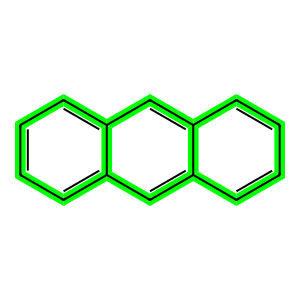

In [8]:
# Anthracene
smiles = "c1ccc2cc3ccccc3cc2c1"
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")
Draw.MolToImage(
    mol,
    highlightBonds=longest_conjugated_bond_chain,
    highlightColor=(0,1,0),
    )

In [9]:
df = pl.read_csv("../data/DB for chromophore_Sci_Data_rev02.csv")

In [10]:
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
1,"""N#Cc1cc2ccc(O)cc2oc1=O""","""O""",355.0,410.0,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.1537,"""DOI: 10.1021/acs.jpcb.5b09905"""
2,"""N#Cc1cc2ccc([O-])cc2oc1=O""","""O""",408.0,450.0,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,"""DOI: 10.1021/acs.jpcb.5b09905"""
3,"""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","""ClC(Cl)Cl""",526.0,535.0,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,"""https://doi.org/10.1002/smll.2…"
4,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CC#N""",514.0,553.72,3.81,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,"""https://doi.org/10.1016/j.snb.…"
5,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CS(C)=O""",524.0,555.0,4.7,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,"""https://doi.org/10.1016/j.snb.…"


In [11]:
df = df.with_columns(pl.col("Absorption max (nm)") - pl.col("Emission max (nm)").alias("Delta (nm)"))

In [ ]:
df.head()

In [12]:
def mol_props(sml, smls_to_match={"repeat_unit": "C#CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12"}):
    """
    Convert SMILES to an RDKit molecule, then calculate various properties of it
    :returns: dictionary of molecular properties
    :param sml: SMILES to convert to a molecule
    """
    mol = Chem.MolFromSmiles(sml)
    CanonicalSMILES = Chem.MolToSmiles(mol)
    longest_bond_indices = get_longest_conjugated_bond_chain(mol)
    length = len(longest_bond_indices)
    return_dict = dict()
    for name, sml_to_match in smls_to_match.items():
        mol_to_match = Chem.MolFromSmiles(sml_to_match)
        # return_dict[f"{name}_has_match"] = mol.HasSubstructMatch(mol_to_match)
        matches = mol.GetSubstructMatches(mol_to_match)
        # # print(f"matches=")
        return_dict[f"{name}_match_count"] = len(matches)

    # print(f"{mol=}, {longest=}")
    return_dict["CanonicalSMILES"] = CanonicalSMILES
    return_dict["longest_bond_length"]=length
    return return_dict
    #     f"longest_bond_indices": longest_bond_indices,
    #     longest_bond_length=length,
    #     has_match = has_match,
    #     num_match = match_count,
    # }
    # return dict(
    #     CanonicalSMILES=CanonicalSMILES,
    #     longest_bond_indices=longest_bond_indices,
    #     longest_bond_length=length,
    #     has_match = has_match,
    #     num_match = match_count,
    #     # matches = matches,
    #     )

Break

In [13]:
tag = 19444
df_filtered = df.filter(Tag=tag)
# print(df_filtered)
try:
   df = df.drop("CanonicalSMILES", "longest_bond_indices", "longest_bond_length", "has_match", "num_match", "matches")
except:
   pass
# df = df_filtered.with_columns(
smls_to_match = {
   "repeat_unit": "C#CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12",
   "too_many_rings": "C#CC1=C2C=C3C=CC=CC3=CC2=C(C#C)C2=CC=CC=C12", # Four benzene rings
   "too_many_rings_N": "C#CC1=C2C=C3N=CC=NC3=CC2=C(C#C)C2=CC=CC=C12", # Three benzene and one dinitrogen ring
   "terminal": "CC(C)[SiH](C(C)C)C(C)C"}
# df = df.head() # Activate for debugging
df = df.with_columns(
   molecular_props = pl.col('Chromophore').map_elements(lambda x: mol_props(x, smls_to_match), return_dtype=pl.Struct)
).unnest('molecular_props').sort("longest_bond_length", descending=True)
df.head()

In [ ]:
df_unique_chromophore = df.unique(subset="Chromophore", maintain_order=True)

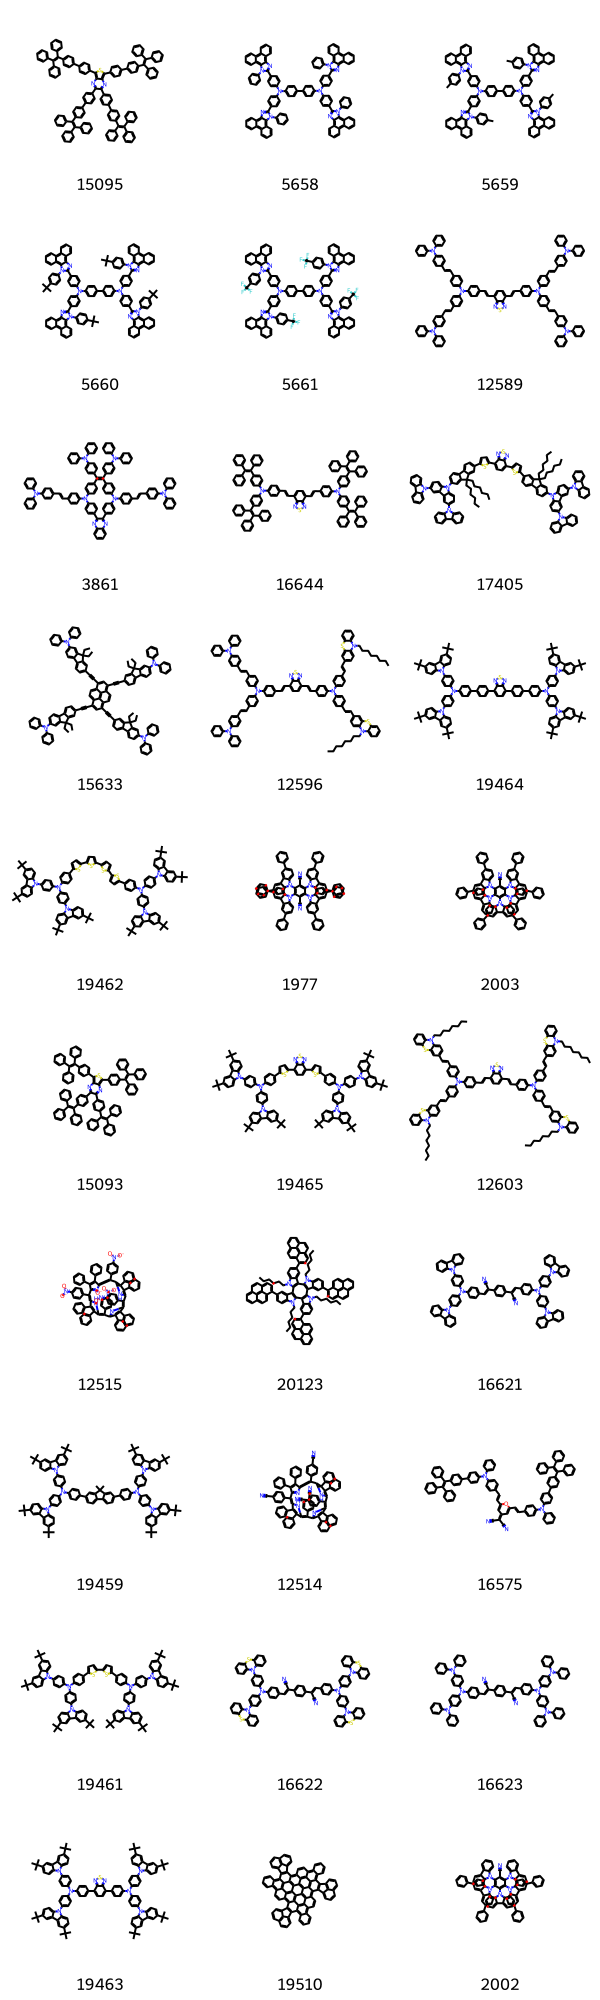

In [ ]:
matching = df_unique_chromophore["Chromophore"].to_list()
tags = df_unique_chromophore["Tag"].to_list()
tags_str = [f"{tag}" for tag in tags]
mols = [Chem.MolFromSmiles(match) for match in matching]
num_compounds = 30
Draw.MolsToGridImage(
    mols = mols[:num_compounds],
    legends = tags_str[:num_compounds],
    )

In [ ]:
# Filter down to a set of reasonably consistent structures where repeat unit count varies
df_matches = df.filter(
    (pl.col("repeat_unit_match_count") > 0) & (
        pl.col("terminal_match_count") == 2) & (
            pl.col("too_many_rings_match_count") == 0) & (
                pl.col("too_many_rings_N_match_count") == 0
            )
        )
df_matches

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,repeat_unit_match_count,too_many_rings_match_count,too_many_rings_N_match_count,terminal_match_count,CanonicalSMILES,longest_bond_length
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64,i64,str,i64
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""",6,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",115
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""",5,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",96
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",4,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",77
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",3,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",58
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",39
19439,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",440.0,461.0,NaN,0.92,4.4133,NaN,NaN,NaN,NaN,651.18004,"""DOI: 10.1021/acs.joc.8b00311""",1,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",20


In [ ]:
df_matches.unique("repeat_unit_match_count")

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,repeat_unit_match_count,too_many_rings_match_count,too_many_rings_N_match_count,terminal_match_count,CanonicalSMILES,longest_bond_length
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64,i64,str,i64
19439,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",440.0,461.0,NaN,0.92,4.4133,NaN,NaN,NaN,NaN,651.18004,"""DOI: 10.1021/acs.joc.8b00311""",1,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",20
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",39
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",3,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",58
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""",5,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",96
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""",6,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",115
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",4,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",77


In [ ]:
df_matches.unique("Chromophore")

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,repeat_unit_match_count,too_many_rings_match_count,too_many_rings_N_match_count,terminal_match_count,CanonicalSMILES,longest_bond_length
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64,i64,str,i64
19439,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",440.0,461.0,NaN,0.92,4.4133,NaN,NaN,NaN,NaN,651.18004,"""DOI: 10.1021/acs.joc.8b00311""",1,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",20
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""",5,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",96
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",3,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",58
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",39
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",4,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",77
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""",6,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",115


In [ ]:
# df_matches_chromophore = df_matches.unique("Chromophore").sort("num_match")
# print(df_matches)
df_matches_chromophore = df_matches.filter(pl.col("Chromophore").str.contains(r"^(.*\[Si\]){2}.*$"))
# print(df_matches_chromophore)
df_matches_chromophore = df_matches_chromophore.sort("repeat_unit_match_count")

matching = df_matches_chromophore["Chromophore"].to_list()
print(len(matching), matching)
mols = [Chem.MolFromSmiles(match) for match in matching]
print(f"{len(mols)=}")
num_match = df_matches_chromophore["repeat_unit_match_count"].to_list()
print(len(num_match), num_match)
absorbance_nm = df_matches_chromophore["Absorption max (nm)"].to_list()
print(len(absorbance_nm), absorbance_nm)
legends = []
for index in range(len(num_match)):
    legends.append(f"{num_match[index]}, {absorbance_nm[index]}")
print(legends)
df_matches_chromophore

6 ['CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)cc2c(C#C[Si](C(C)C)(C(C)C)C(C)C)c2ccc(C(C)(C)C)cc12)(C(C)C)C(C)C', 'CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)cc2c(C#Cc2c3ccc(C(C)(C)C)cc3c(C#C[Si](C(C)C)(C(C)C)C(C)C)c3ccc(C(C)(C)C)cc23)c2ccc(C(C)(C)C)cc12)(C(C)C)C(C)C', 'CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)cc2c(C#Cc2c3ccc(C(C)(C)C)cc3c(C#Cc3c4ccc(C(C)(C)C)cc4c(C#C[Si](C(C)C)(C(C)C)C(C)C)c4ccc(C(C)(C)C)cc34)c3ccc(C(C)(C)C)cc23)c2ccc(C(C)(C)C)cc12)(C(C)C)C(C)C', 'CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2c3ccccc3c(C#Cc3c4ccccc4c(C#Cc4c5ccccc5c(C#C[Si](C(C)C)(C(C)C)C(C)C)c5ccccc45)c4ccccc34)c3ccccc23)c2ccccc12)(C(C)C)C(C)C', 'CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2c3ccccc3c(C#Cc3c4ccccc4c(C#Cc4c5ccccc5c(C#Cc5c6ccccc6c(C#C[Si](C(C)C)(C(C)C)C(C)C)c6ccccc56)c5ccccc45)c4ccccc34)c3ccccc23)c2ccccc12)(C(C)C)C(C)C', 'CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2c3ccccc3c(C#Cc3c4ccccc4c(C#Cc4c5ccccc5c(C#Cc5c6ccccc6c(C#Cc6c7ccccc7c(C#C[Si](C(C)C)(C(C)C)C(C)C)c7ccccc67)c6ccccc56)c5ccccc45)c4ccccc34)c3ccccc23)c2ccccc12)(C(C)C)C(C)C']
len(mols)=6
6 [1, 2, 3, 4, 5, 6]
6

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,repeat_unit_match_count,too_many_rings_match_count,too_many_rings_N_match_count,terminal_match_count,CanonicalSMILES,longest_bond_length
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64,i64,str,i64
19439,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",440.0,461.0,NaN,0.92,4.4133,NaN,NaN,NaN,NaN,651.18004,"""DOI: 10.1021/acs.joc.8b00311""",1,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",20
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",39
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",3,0,0,2,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…",58
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",4,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",77
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""",5,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",96
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""",6,0,0,2,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…",115


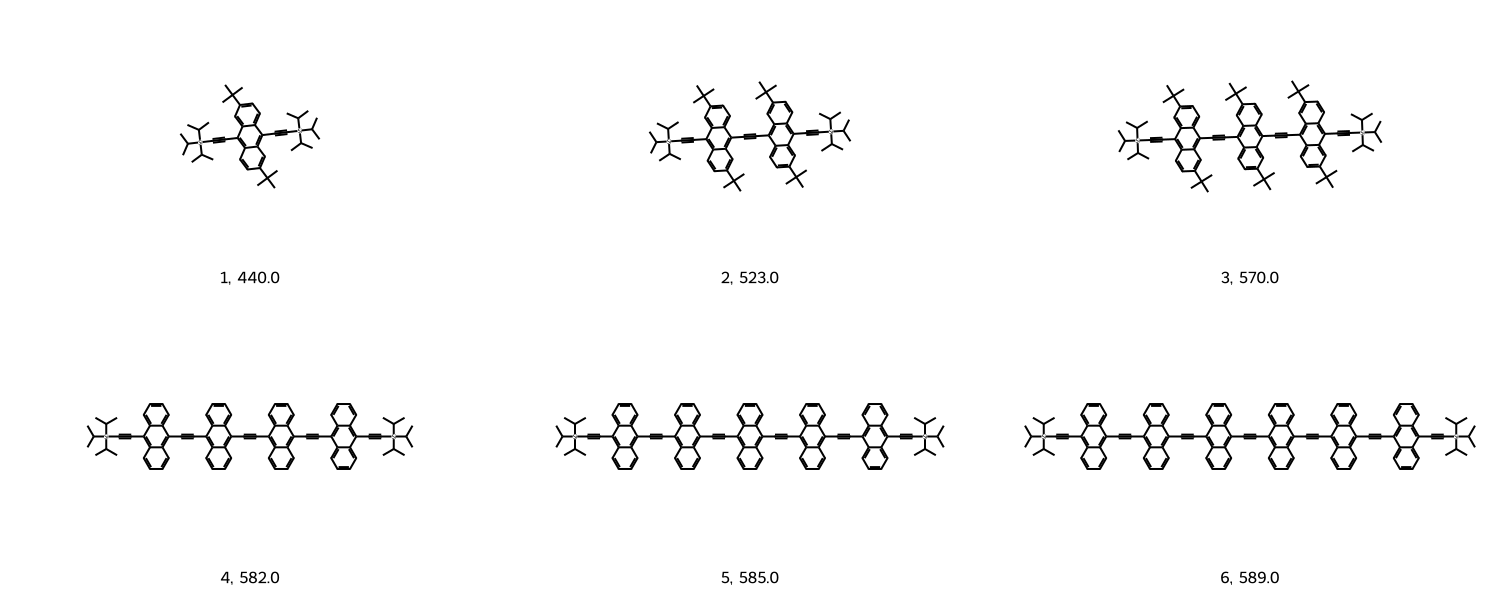

In [ ]:
Draw.MolsToGridImage(
    mols = mols,
    legends = legends,
    subImgSize=(500, 300),
    maxMols = 100,
)

In [ ]:
df_matches.shrink_to_fit()
df_matches.plot.scatter(x="repeat_unit_match_count", y="Absorption max (nm)")

alt.Chart(...)

In [ ]:
df_matches.plot.scatter(x="longest_bond_length", y="Absorption max (nm)")

alt.Chart(...)

In [ ]:
import altair as alt

# First scatter plot for "Absorption max (nm)"
scatter_absorption = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Absorption max (nm)',
    color=alt.value('blue')  # Optional: to differentiate by color
).properties(
    title='Absorption and Emission Max Scatter Plot'
)

# Second scatter plot for "Emission max (nm)"
scatter_emission = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Emission max (nm)',
    color=alt.value('red')  # Optional: to differentiate by color
)

# Layer both scatter plots
layered_chart = alt.layer(scatter_absorption, scatter_emission).interactive()
layered_chart.
layered_chart.show()

alt.LayerChart(...)

In [ ]:
# Calculate the minimum y-value across both series
min_y_value = min(df_matches['Absorption max (nm)'].min(), df_matches['Emission max (nm)'].min())
y_min = min_y_value * 0.95  # Adjust to 95% of the minimum value for a slight buffer
max_y_value = max(df_matches['Absorption max (nm)'].max(), df_matches['Emission max (nm)'].max())
y_max = max_y_value * 1.05  # Adjust to 105% of the maximum value for a slight buffer
max_x_value = df_matches['repeat_unit_match_count'].max() + 0.5

# First scatter plot for "Absorption max (nm)"
scatter_absorption = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Absorption max (nm)',
    color=alt.value('blue')
)

# Second scatter plot for "Emission max (nm)"
scatter_emission = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Emission max (nm)',
    color=alt.value('red')
)

# Layer both scatter plots and set the y-axis minimum value for the whole chart
layered_chart = alt.layer(scatter_absorption, scatter_emission).properties(
    title='Absorption and Emission Max Scatter Plot'
).encode(
    y=alt.Y('Absorption max (nm)', scale=alt.Scale(domain=[y_min, y_max])),  # Set the y-axis scale globally
    x=alt.X('repeat_unit_match_count', scale=alt.Scale(domain=[0, max_x_value])),  # Set the x-axis scale globally
).interactive()

layered_chart.show()

alt.LayerChart(...)

In [ ]:
df_matches.plot.scatter(x="repeat_unit_match_count", y="Emission max (nm)")

alt.Chart(...)

In [ ]:
# matches = df[0]["matches"].item().to_list()
# for match in matches:
#     print(match.sort())
# matches

In [ ]:
sml_terminal = "CC(C)[SiH](C(C)C)C(C)C"


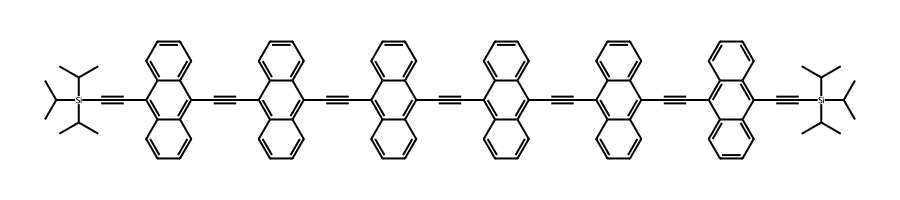

In [ ]:
smiles=df_filtered[0]["Chromophore"].item()
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(
    mol,
    # highlightAtoms=matches[0],
    highlightColor=(0,1,0),
    size=(900,200),
    useSVG=True,
    )

In [ ]:
smiles

'CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2c3ccccc3c(C#Cc3c4ccccc4c(C#Cc4c5ccccc5c(C#Cc5c6ccccc6c(C#Cc6c7ccccc7c(C#C[Si](C(C)C)(C(C)C)C(C)C)c7ccccc67)c6ccccc56)c5ccccc45)c4ccccc34)c3ccccc23)c2ccccc12)(C(C)C)C(C)C'

In [ ]:
best1 = df.filter((abs(pl.col("Absorption max (nm)")-440.0) < 1) & (pl.col("num_match") > 0))
best1

ColumnNotFoundError: unable to find column "num_match"; valid columns: ["Tag", "Chromophore", "Solvent", "Absorption max (nm)", "Emission max (nm)", "Lifetime (ns)", "Quantum yield", "log(e/mol-1 dm3 cm-1)", "abs FWHM (cm-1)", "emi FWHM (cm-1)", "abs FWHM (nm)", "emi FWHM (nm)", "Molecular weight (g mol-1)", "Reference", "repeat_unit_match_count", "too_many_rings_match_count", "too_many_rings_N_match_count", "terminal_match_count", "CanonicalSMILES", "longest_bond_length"]

In [ ]:
best1_smiles = best1[0]["Chromophore"].item()
print(best1_smiles)

CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)cc2c(C#C[Si](C(C)C)(C(C)C)C(C)C)c2ccc(C(C)(C)C)cc12)(C(C)C)C(C)C


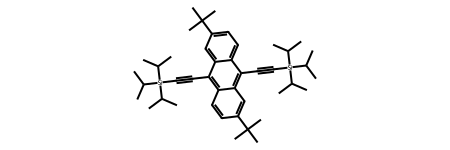

In [ ]:
best1_mol = Chem.MolFromSmiles(best1_smiles)
best1_mol

In [ ]:
df.filter(pl.col("Chromophore")=='CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2c3ccccc3c(C#Cc3c4ccccc4c(C#Cc4c5ccccc5c(C#Cc5c6ccccc6c(C#Cc6c7ccccc7c(C#C[Si](C(C)C)(C(C)C)C(C)C)c7ccccc67)c6ccccc56)c5ccccc45)c4ccccc34)c3ccccc23)c2ccccc12)(C(C)C)C(C)C')

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length,has_match,num_match
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,list[i64],i64,bool,i64
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""","""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","[4, 5, … 134]",115,true,6


In [ ]:
df.select(pl.all().exclude("longest_bond_indices")).write_csv("../data/DB for chromophore_Sci_Data_rev02_conjugated.csv")

In [ ]:
df.sort("longest_bond_length")

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length,has_match,num_match
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,list[i64],i64,bool,i64
12377,"""C1C[C@H]2CC[C@@H]1N=N2""","""CC#N""",NaN,NaN,434.0,0.39,NaN,NaN,NaN,NaN,NaN,110.1594,"""DOI: 10.1021/jo990206m""","""C1C[C@H]2CC[C@@H]1N=N2""",[],0,false,0
12379,"""C=C[C@]12CC[C@H](CC1)N=N2""","""CC#N""",NaN,NaN,0.56,0.0009,NaN,NaN,NaN,NaN,NaN,136.19728,"""DOI: 10.1021/jo990206m""","""C=C[C@]12CC[C@H](CC1)N=N2""",[],0,false,0
12383,"""O=CC12N=N[C@](C=O)(C3C4CCC(C4)…","""CC#N""",NaN,NaN,111.0,0.049,NaN,NaN,NaN,NaN,NaN,298.38468,"""DOI: 10.1021/jo990206m""","""O=CC12N=N[C@](C=O)(C3C4CCC(C4)…",[],0,false,0
12384,"""C=CC12N=N[C@](C=C)(C3C4CCC(C4)…","""CC#N""",NaN,NaN,268.0,0.16,NaN,NaN,NaN,NaN,NaN,294.44044,"""DOI: 10.1021/jo990206m""","""C=CC12N=N[C@](C=C)(C3C4CCC(C4)…",[],0,false,0
12385,"""CCC12N=N[C@](CC)(C3C4CCC(C4)C3…","""CC#N""",NaN,NaN,263.0,0.19,NaN,NaN,NaN,NaN,NaN,298.4722,"""DOI: 10.1021/jo990206m""","""CCC12N=N[C@](CC)(C3C4CCC(C4)C3…",[],0,false,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5663,"""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…","""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…",NaN,525.0,0.0374,NaN,NaN,NaN,NaN,NaN,140.3,1714.10096,"""https://doi.org/10.1016/j.orge…","""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…","[1, 2, … 158]",155,false,0
5664,"""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…","""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…",NaN,510.0,0.138,NaN,NaN,NaN,NaN,NaN,141.1,1882.42352,"""https://doi.org/10.1016/j.orge…","""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…","[4, 5, … 170]",155,false,0
5665,"""FC(F)(F)c1ccc(-n2c(-c3ccc(N(c4…","""FC(F)(F)c1ccc(-n2c(-c3ccc(N(c4…",NaN,526.0,0.0288,NaN,NaN,NaN,NaN,NaN,149.8,1929.98168,"""https://doi.org/10.1016/j.orge…","""FC(F)(F)c1ccc(-n2c(-c3ccc(N(c4…","[4, 5, … 170]",155,false,0


shape: (1, 19)
┌───────┬────────────┬───────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Tag   ┆ Chromophor ┆ Solvent   ┆ Absorption ┆ … ┆ longest_bo ┆ longest_b ┆ has_match ┆ num_match │
│ ---   ┆ e          ┆ ---       ┆ max (nm)   ┆   ┆ nd_indices ┆ ond_lengt ┆ ---       ┆ ---       │
│ i64   ┆ ---        ┆ str       ┆ ---        ┆   ┆ ---        ┆ h         ┆ bool      ┆ i64       │
│       ┆ str        ┆           ┆ f64        ┆   ┆ list[i64]  ┆ ---       ┆           ┆           │
│       ┆            ┆           ┆            ┆   ┆            ┆ i64       ┆           ┆           │
╞═══════╪════════════╪═══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 19444 ┆ CC(C)[Si]( ┆ Cc1ccccc1 ┆ 589.0      ┆ … ┆ [4, 5, …   ┆ 115       ┆ true      ┆ 6         │
│       ┆ C#Cc1c2ccc ┆           ┆            ┆   ┆ 134]       ┆           ┆           ┆           │
│       ┆ cc2c(C#Cc2 ┆           ┆            ┆   ┆            ┆           ┆

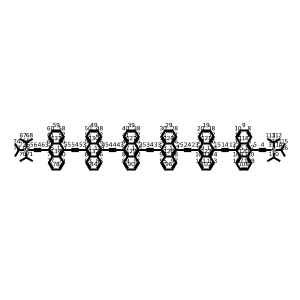

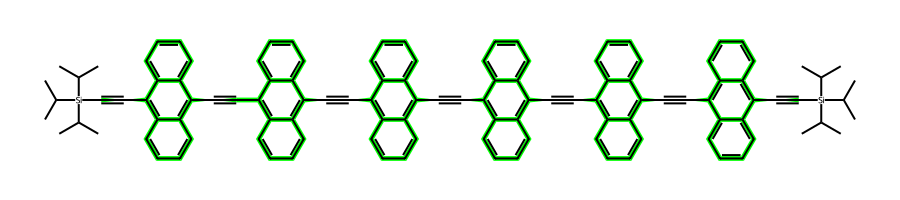

In [ ]:
# Selected molecule from optical data set
# smiles='CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C1=O)c64)C(=O)N(CCCCCCCCCC#CC#CCCCCCCCCCCCC)C5=O'
tag = 19444
# tag = 15096
df_filtered = df.filter(Tag=tag)
print(df_filtered)
smiles=df_filtered[0]["Chromophore"].item()
conjugated_bonds = df_filtered[0]["longest_bond_indices"].item().to_list()
print(f"{smiles=}")
print(f"{conjugated_bonds=}")
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
# print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")
label_bonds(mol)
Draw.MolToImage(
    mol,
    highlightBonds=conjugated_bonds,
    highlightColor=(0,1,0),
    size=(900,200),
    useSVG=True,
    )

In [ ]:
Chem.MolToSmarts(mol)

'[#6]-[#6](-[#6])-[Si](-[#6]#[#6]-[#6]1:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6](-[#6]#[#6]-[#6]2:[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3:[#6](-[#6]#[#6]-[#6]3:[#6]4:[#6]:[#6]:[#6]:[#6]:[#6]:4:[#6](-[#6]#[#6]-[#6]4:[#6]5:[#6]:[#6]:[#6]:[#6]:[#6]:5:[#6](-[#6]#[#6]-[#6]5:[#6]6:[#6]:[#6]:[#6]:[#6]:[#6]:6:[#6](-[#6]#[#6]-[#6]6:[#6]7:[#6]:[#6]:[#6]:[#6]:[#6]:7:[#6](-[#6]#[#6]-[Si](-[#6](-[#6])-[#6])(-[#6](-[#6])-[#6])-[#6](-[#6])-[#6]):[#6]7:[#6]:[#6]:[#6]:[#6]:[#6]:6:7):[#6]6:[#6]:[#6]:[#6]:[#6]:[#6]:5:6):[#6]5:[#6]:[#6]:[#6]:[#6]:[#6]:4:5):[#6]4:[#6]:[#6]:[#6]:[#6]:[#6]:3:4):[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:2:3):[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:1:2)(-[#6](-[#6])-[#6])-[#6](-[#6])-[#6]'

[#6]-[#6]1:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6](-[#6]#[#6]):[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:1:2


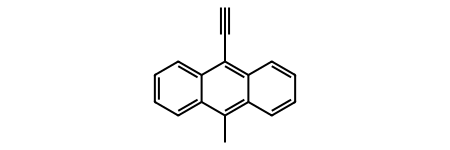

In [ ]:
# sml_unit = 'C#CC1=C2C=CC=CC2=CC2=CC=CC=C12'
sml_unit = "CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12"
mol_unit = Chem.MolFromSmiles(sml_unit)
smarts_unit = Chem.MolToSmarts(mol_unit)
print(smarts_unit)
mol_unit

In [ ]:
mol.HasSubstructMatch(mol_unit)

True

Blank

Longest conjugated bond chain length is 15 with bond indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


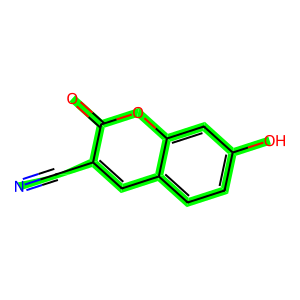

In [ ]:
# First molecule from optical data set
smiles='N#Cc1cc2ccc(O)cc2oc1=O'
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")

Draw.MolToImage(
    mol,
    highlightBonds=longest_conjugated_bond_chain,
    highlightColor=(0,1,0),
    )